<!-- #region -->
# 优化与深度学习

在本节中，我们将讨论优化与深度学习之间的关系，以及在深度学习中使用优化所面临的挑战。
对于深度学习问题，我们通常首先定义一个损失函数，一旦我们有了损失函数，我们就可以使用一个优化算法来尝试最小化损失。
在最优化中，损失函数通常被称为最优化问题的目标函数。
根据传统和惯例，大多数优化算法都与“最小化”有关。
如果我们需要最大化一个目标，有一个简单的解决方案：只要翻转目标上的标志。

## 优化与估算

虽然优化为深度学习提供了一种最小化损失函数的方法，但从本质上讲，优化和深度学习的目标是完全不同的。
前者主要关注最小化目标，而后者关注在给定有限数据量的情况下找到合适的模型。
在 :numref:`sec_model_selection` 中，我们详细讨论了这两个目标之间的差异。
例如，训练误差和泛化误差一般是不同的：由于优化算法的目标函数通常是基于训练数据集的损失函数，所以优化的目标是减少训练误差。
然而，统计推断（以及深度学习）的目标是减少泛化误差。
为了实现后者，除了使用优化算法来减少训练误差外，还需要注意过拟合问题。
我们首先导入一些深度学习算法库。


In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from mpl_toolkits import mplot3d
from d2l import tensorflow as d2l


接下来我们定义两个函数，期望函数 $f$ 和经验函数 $g$ ，来说明这个问题。这里的 $g$ 不如 $f$ 平滑，因为我们只有有限的数据量。


In [2]:
def f(x):
    return x * tf.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * tf.cos(5 * np.pi * x)

下图说明了训练误差的最小值可能与预期误差（或测试误差）的最小值在不同的位置。


In [3]:
def annotate(text, xy, xytext):  #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = tf.range(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('empirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('expected risk', (1.1, -1.05), (0.95, -0.5))

## 深度学习中的优化挑战

在本章中，我们将特别关注优化算法在最小化目标函数方面的性能，而不是模型的泛化误差。
在 :numref:`sec_linear_regression` 中，我们区分了最优化问题的解析解和数值解。
在深度学习中，大多数目标函数是复杂的，没有解析解。
相反，我们必须使用数值优化算法。下面的优化算法都属于这一类。

深度学习优化面临许多挑战，其中最令人烦恼的是局部极小值、鞍点和消失梯度。
下面让我们具体了解一下这些挑战。

### 局部最小值

对于目标函数 $f(x)$，如果 $x$ 处的 $f(x)$ 值小于 $x$ 附近任何其他点的 $f(x)$ 值，则 $f(x)$ 可以是*局部最小值*（local minimum）。
如果 $f(x)$ 在 $x$ 处的值是目标函数在整个域上的最小值，则 $f(x)$ 是*全局最小值*（global minimum）。

例如，给定函数

$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$$

我们可以近似这个函数的局部最小值和全局最小值。


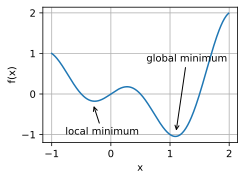

In [4]:
x = tf.range(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x),], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

深度学习模型的目标函数通常具有许多局部最优解。
当优化问题的数值解接近局部最优解时，当目标函数解的梯度下降接近零时，通过最终迭代得到的数值解只可能使目标函数局部最小化，而不是全局最小化。
只有一定程度的噪声才能使参数超出局部极小值。
事实上，这是随机梯度下降的一个有利性质，在这种情况下，小批量梯度的自然变化能够将参数从局部极小值中去除。

### 鞍点

除了局部极小值，*鞍点*（saddle point）是梯度消失的另一个原因。
鞍点是函数的所有梯度都消失但既不是全局最小值也不是局部最小值的任何位置。
考虑函数 $f(x) = x^3$，它的一阶导数和二阶导数在 $x=0$ 处消失。
优化可能会在某个点停止，即使它不是最小值。


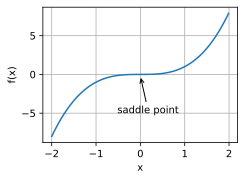

In [5]:
x = tf.range(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

更高维度中的鞍点更为隐蔽，如下例所示，考虑函数 $f(x, y) = x^2 - y^2$。
它的鞍点在 $(0, 0)$，这是 $y$ 的最大值，$x$ 的最小值。
它看起来像一个马鞍，这就是这个数学性质的由来。


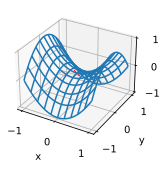

In [6]:
x, y = tf.meshgrid(tf.linspace(-1.0, 1.0, 101), tf.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

我们假设一个函数的输入是一个$k$维向量，其输出是一个标量，因此它的Hessian矩阵将有$k$个特征值（参见 :numref:`sec_geometry-linear-algebraic-ops`）。
函数的解可以是局部最小值、局部最大值或函数梯度为零的位置处的鞍点：

* 当函数的Hessian矩阵在零梯度位置的特征值都为正时，我们得到了函数的局部极小值。
* 当函数的Hessian矩阵在零梯度位置的特征值都为负时，我们得到了函数的局部极大值。
* 当函数的Hessian矩阵在零梯度位置的特征值为负和正时，我们得到了函数的鞍点。

对于高维问题，至少某些特征值为负的可能性是相当高的，这使得鞍点比局部极小值更有可能。
我们将在下一节介绍凸性时讨论这种情况的一些例外情况。简而言之，*凸函数*是那些Hessian函数的特征值从不为负的函数。
遗憾的是，大多数深层次的学习问题并不属于这一类。然而，它是一个伟大的工具，研究优化算法。

### 消失梯度

*消失梯度*（vanishing gradients）可能是我们会遇到的最隐秘的问题。
例如，假设我们想最小化函数 $f(x) = \tanh(x)$，我们恰好从 $x = 4$ 开始。
如我们所见，$f$ 的梯度接近于零，更具体地说是$f'(x) = 1 - \tanh^2(x)$和$f'(4) = 0.0013$。
因此，在我们取得进展之前，优化将被困很长一段时间。
这就是为什么在引入ReLU激活函数之前，深度学习模型的训练相当棘手的原因之一。


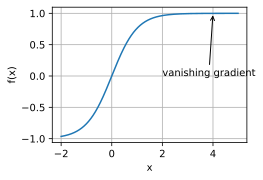

In [7]:
x = tf.range(-2.0, 5.0, 0.01)
d2l.plot(x, [tf.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

正如我们所看到的，深度学习的优化充满了挑战。
幸运的是，有一个强大的算法范围，表现良好，易于使用，即使是初学者。
此外，其实没有必要找到最佳解决方案，局部最优解甚至近似解仍然非常有用。


## 小结

* 最小化训练误差并不能保证我们找到一组最佳的参数来最小化期望误差。
* 优化问题可能存在许多局部极小值。
* 一般机器学习问题都不是凸性的，所以优化问题可能有许多鞍点。
* 逐渐消失的梯度会导致优化停滞，通常问题的重新参数化会有所帮助。良好初始化的参数也可能是有益的。

## 练习

1. 考虑一个简单的多层感知器，在隐层中有一个$d$维的隐层和一个输出。证明任何当地最低有至少 $d!$ 行为相同的等价解。
1. 假设我们有一个对称随机矩阵 $\mathbf{M}$，其中条目 $M_{ij} = M_{ji}$ 分别来自某个概率分布 $p_{ij}$。此外，假设 $p_{ij}(x) = p_{ij}(-x)$，即分布是对称的（详见 :cite:`Wigner.1958` ）。
    * 证明了特征值上的分布也是对称的。即，对于任何特征向量 $\mathbf{v}$，相关特征值 $\lambda$ 满足 $P(\lambda > 0) = P(\lambda < 0)$ 的概率。
    * 为什么上面的*不是*意味着 $P(\lambda > 0) = 0.5$？
1. 在深度学习优化过程中，你还能想到哪些挑战？
1. 假设你想在一个（真实的）马鞍上平衡一个（真实的）球。
    * 为什么这么难？
    * 你能利用这种效果也优化算法吗？


[Discussions](https://discuss.d2l.ai/t/489)


<!-- #endregion -->
